In [60]:
import os
import numpy as np
import pandas as pd
import pickle
from time import sleep
from random import randint

from sklearn import datasets # sklearn comes with some toy datasets to practise
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import config
import spotipy
import json
from spotipy.oauth2 import SpotifyClientCredentials

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [61]:
#Initialize SpotiPy with user credentias
sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id= config.client_id,
                                                           client_secret= config.client_secret))

In [18]:
def load(filename = "filename.pickle"): 
    try: 
        with open(filename, "rb") as f: 
            return pickle.load(f) 
        
    except FileNotFoundError: 
        print("File not found!") 

In [30]:
## load data
indir_list = ['music/audio features_miri/', 'Data/audio_features2/', 'zoe/features/aaron_oh_experience/',
'zoe/features/party_songs/', 'zoe/features/playlists/', 'zoe/features/ultimate_party_mix/']

required_cols = ['id', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 
                 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature']

infile_list = []
for indir in indir_list:
    infile_list += [f"{indir}{x}" for x in os.listdir(indir)]

dfs = []
for fname in infile_list:
    if fname.endswith(".csv"):
        tempdf = pd.read_csv(fname, index_col=None)
        dfs.append(tempdf[required_cols])
    
df = pd.concat(dfs, axis=0)
df = df.drop_duplicates().reset_index(drop=True)


In [31]:
df.shape

(51524, 14)

In [33]:
## drop id and keep the rest
X = df.drop('id', axis=1).reset_index(drop=True)

In [34]:
## normalize
scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns = X.columns)

In [35]:
scaler_filename =  "Model/big-scaler.pickle"
with open(scaler_filename, "wb") as f:
    pickle.dump(scaler,f)
print(f'Saved StandardScaler model as: {scaler_filename}')

Saved StandardScaler model as: Model/big-scaler.pickle


In [36]:
K = range(2, 13)
silhouette = []
inertia = []

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=1337)
    kmeans.fit(X_scaled_df)
    
    filename = f"Model/big_kmeans_{k}.pickle"
    with open(filename, "wb") as f:
        pickle.dump(kmeans,f)
    
    inertia.append(kmeans.inertia_)
    silhouette.append(silhouette_score(X_scaled_df, kmeans.predict(X_scaled_df)))


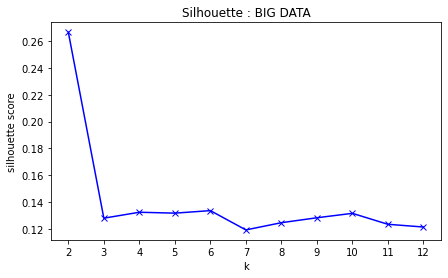

In [41]:
### ---- plot silhouette  ------
plt.figure(figsize=(7,4))
plt.plot(K, silhouette, 'bx-')
plt.xlabel('k')
plt.ylabel('silhouette score')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.title('Silhouette : BIG DATA')
plt.show()

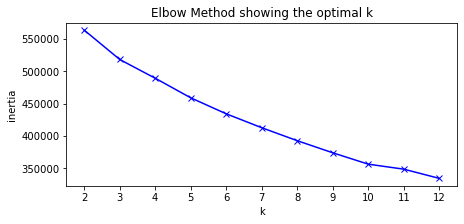

In [39]:
plt.figure(figsize=(7,3))
plt.plot(K, inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('inertia')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.title('Elbow Method showing the optimal k')
plt.show()

# Extract cluster label assignment for k=6 and k=10

In [42]:
def assess_k_cluster_assignments(kval, df, X_scaled_df):
    ## load the trained model with the k == kval
    kmeans = load(f"Model/big_kmeans_{kval}.pickle")

    cluster_run_name = f'k{kval}_cluster'
    # create new col in main df with the cluster label the model assigned to each track
    df[cluster_run_name] = kmeans.labels_

    ## create dictionary of cluster membership for each label
    cluster_labels = np.unique(df[cluster_run_name])
    cluster_members = {}
    for cluster in cluster_labels:
        cluster_members[cluster] = np.where(df[cluster_run_name] == cluster)

    ## for each cluster label (ky) calculate the mean for each feature
    scaled_feature_means_by_cluster = pd.DataFrame([X_scaled_df.loc[cluster_members[ky]].mean(numeric_only=True) for ky in cluster_members.keys()])

    ## --- plot results as heatmap
    with sns.axes_style("white"):
        f, ax = plt.subplots(figsize=(15, 15))
        ax = sns.heatmap(scaled_feature_means_by_cluster, cmap='coolwarm', vmin=-1, vmax=1, annot=True, square=True)
        
    return df
    

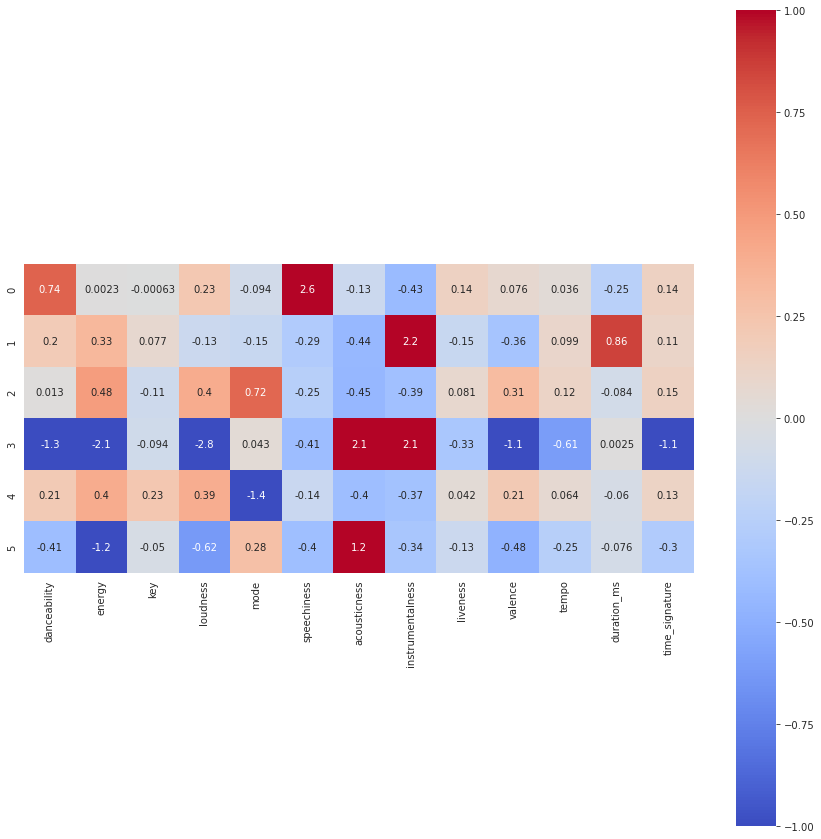

In [44]:
df = assess_k_cluster_assignments(6, df, X_scaled_df)


In [45]:
df.k6_cluster.value_counts()

2    19872
4    11120
5     8097
1     4811
0     4792
3     2832
Name: k6_cluster, dtype: int64

In [47]:
df.k10_cluster.value_counts()

6    12654
7     9451
9     7459
0     5927
1     4338
5     4080
2     2832
4     2435
8     2301
3       47
Name: k10_cluster, dtype: int64

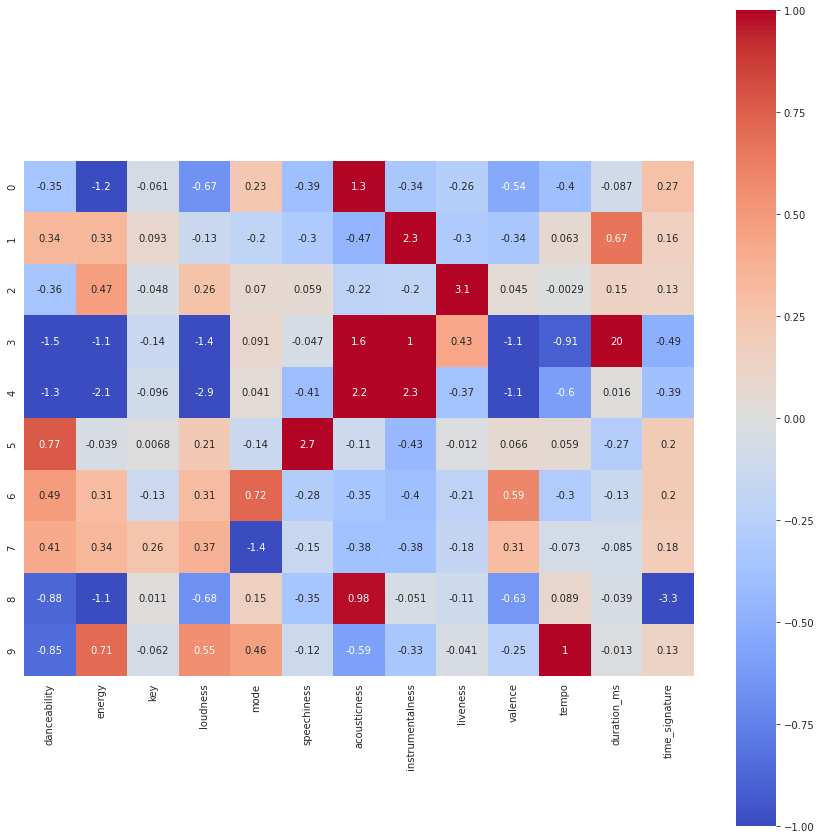

In [46]:
df = assess_k_cluster_assignments(10, df, X_scaled_df)


## Add artist name and track title 

In [49]:
def display_artist(track_info):
## create a single string with all artist names
    return " / ".join([x['name'] for x in track_info['artists']])

In [48]:
df.columns

Index(['id', 'danceability', 'energy', 'key', 'loudness', 'mode',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'duration_ms', 'time_signature', 'k6_cluster',
       'k10_cluster'],
      dtype='object')

In [50]:
## create smaller df with just the id and the cluster labels
id_and_labels_df = df[['id', 'k6_cluster', 'k10_cluster']]


In [85]:
id_and_labels_df.shape

(51524, 3)

In [84]:
id_and_labels_df.to_csv('Data/db/FULL_big_data_id_and_cluster_labels.csv')

In [63]:
## use the ids to get the title (name) and artist info for each track

titles=[]
artists=[]
pp_artist=[]
counter = 0
file_counter = 1
max_count = 5000
n=0

for i in range(5000, id_and_labels_df.shape[0]):
    trackid = id_and_labels_df.id[i]
    n+=1
    if counter == max_count:
        # time to print results
        file_counter += 1
        tracks_to_print = pd.concat([id_and_labels_df[(file_counter-1)*max_count:file_counter*max_count], 
                                     pd.DataFrame({'title': titles, 
                                                   'artists': artists, 
                                                   'pp_artist': pp_artist})], axis=1)
        
        outfilename = f'Data/db/big_data{file_counter}.csv'
        tracks_to_print.to_csv(outfilename, index=False)
        print(f"Created file ({counter} tracks): {outfilename}")
        
        
        titles=[]
        artists=[]
        pp_artist=[]
        counter = 0

    if n % 400 == 0:
        print(f'processed {n} records!')
        
    track_info = sp.track(trackid, market='GB')
    titles.append(track_info['name'])
    artists.append([x['name'] for x in track_info['artists']])
    pp_artist.append(display_artist(track_info))
    counter += 1
   
## end of loop -- print the rest
file_counter += 1
tracks_to_print = pd.concat([id_and_labels_df[(file_counter-1)*max_count:file_counter*max_count], 
                             pd.DataFrame({'title': titles, 
                                           'artists': artists, 
                                           'pp_artist': pp_artist})], axis=1)

outfilename = f'Data/db/big_data{file_counter}.csv'
tracks_to_print.to_csv(outfilename, index=False)
print(f"Created file ({counter} tracks): {outfilename}")

nap time!
nap time!
nap time!
nap time!
nap time!
Created file (5000 tracks): Data/db/big_data1.csv
nap time!
nap time!
nap time!
nap time!
nap time!


KeyboardInterrupt: 

In [77]:
len(titles)

4586

In [78]:
id_and_labels_df[(file_counter-1)*max_count:(file_counter-1)*max_count+len(titles)].shape

(4586, 3)

In [79]:
## end of loop -- print the rest
#file_counter += 1 -- leave at 2
tracks_to_print = pd.concat([id_and_labels_df[(file_counter-1)*max_count:(file_counter-1)*max_count+len(titles)], 
                             pd.DataFrame({'title': titles, 
                                           'artists': artists, 
                                           'pp_artist': pp_artist})], axis=1)

outfilename = f'Data/db/big_data{file_counter}.csv'
tracks_to_print.to_csv(outfilename, index=False)
print(f"Created file ({counter} tracks): {outfilename}")

Created file (4586 tracks): Data/db/big_data2.csv


In [81]:
tracks_to_print.shape

(9172, 6)

In [75]:
track_info['name']

'Raise Your Banner - Single Edit'